## Chapter 5: Speech communications

### 5.2 Parameterisation

#### 5.2.1 Linear prediction

##### 5.2.1.1 The LPC filter

In [1]:
import numpy as np
from scipy.signal import lfilter, hamming
from scipy.linalg import toeplitz

# 예시로 speech 신호를 생성 (실제 신호가 있다고 가정)
speech = np.random.randn(1600)  # 예시: 1600개의 랜덤 신호

# 첫 160개의 샘플 선택
seg = speech[:160]

# 해밍 창 적용
wseg = seg * hamming(160)

# LPC 계산 함수 (order 차수만큼 LPC 계수 계산)
def lpc(signal, order):
    # 오토 상관 함수 계산
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr) // 2:]  # 양의 지연만 사용
    
    # Toeplitz 행렬 생성
    R = toeplitz(autocorr[:order])
    r = autocorr[1:order + 1]
    
    # LPC 계수 계산 (Yule-Walker 방정식)
    lpc_coeffs = np.linalg.solve(R, r)
    
    # LPC 계수 반환 (1을 추가해 전체 계수로 반환)
    return np.concatenate(([1], -lpc_coeffs))

# LPC 계수 계산 (차수 10)
a = lpc(wseg, 10)

# 결과 출력
print("LPC coefficients:", a)

LPC coefficients: [ 1.         -0.07856689  0.03145775  0.1422262   0.06401753 -0.06793161
 -0.11100035 -0.0337389   0.01696994 -0.05698843  0.08474846]


In [2]:
from scipy.signal import freqz

# 주파수 응답 계산
w, h = freqz(b=[1], a=a)

In [3]:
# 주파수 응답 계산
w, h = freqz(a)

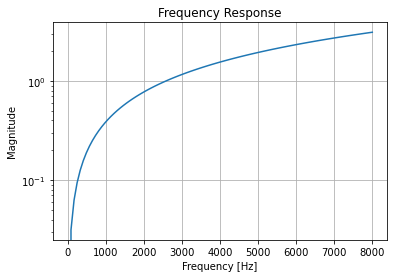

Peak Frequency: 8000.0 Hz


In [4]:
import matplotlib.pyplot as plt

# 파라미터 설정
Fs = 8000  # 샘플링 속도 (Hz)
N = 100  # 주파수 해상도

# 'a'는 이전에 계산된 LPC 계수 또는 필터 계수라고 가정합니다.

# freqz 함수를 사용하여 주파수 응답 계산
H, F = freqz([1], a, N)

# 절대값을 사용하여 로그 스케일로 플로팅
frequencies = np.linspace(0, Fs, N)  # 주파수 벡터 생성
plt.semilogy(frequencies, np.abs(H))
plt.title('Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

# 주파수 응답에서 최대값 및 그 위치 계산
y = np.max(np.abs(H))
n = np.argmax(np.abs(H))
PeakF = (n * Fs) / (N - 1)

# 결과 출력
print(f"Peak Frequency: {PeakF} Hz")

##### 5.2.1.3 Pre-emphasis of the speech signal

In [5]:
import scipy.signal as signal

# 신호 's'가 이미 정의되어 있다고 가정합니다.
# 예시: s는 임의의 오디오 신호입니다.
s = np.random.randn(1000)  # 예시로 랜덤 신호 생성

# 강조/디-엠파시스 필터 계수 설정
h = [1, -0.9375]

# 강조 필터 적용
es = signal.lfilter(h, [1], s)

# 디-엠파시스 필터 적용
ds = signal.lfilter([1], h, es)

# 결과 확인
print("Emphasized Signal (es):", es[:10])  # 처음 10개의 샘플 출력
print("De-emphasized Signal (ds):", ds[:10])  # 처음 10개의 샘플 출력

Emphasized Signal (es): [-0.80406512  0.8369731  -0.49146015  1.10187592 -0.90772995  0.52192324
 -0.44095299  0.22702236 -0.9584804   0.41673963]
De-emphasized Signal (ds): [-0.80406512  0.08316206 -0.41349572  0.71422369 -0.23814524  0.29866207
 -0.1609573   0.07612489 -0.88711331 -0.4149291 ]


##### 5.2.4.1 Derivation of LSPs

In [6]:
import numpy as np

def lpc_lsp(a):
    p = len(a)
    A = [1]
    B = [1]

    # A와 B의 값 계산
    for k in range(1, p):
        A.append((a[k] - a[p - k]) + A[k - 1])
        B.append((a[k] + a[p - k]) - B[k - 1])

    # 다항식의 근 계산
    r1 = np.roots(A)
    r2 = np.roots(B)

    theta1 = []
    theta2 = []

    # theta1과 theta2 계산
    for k in range(p - 1):
        if np.real(r1[k]) < 0:
            theta1.append(np.pi - abs(np.arctan2(np.imag(r1[k]), np.real(r1[k]))))
        else:
            theta1.append(abs(np.arctan2(np.imag(r1[k]), np.real(r1[k]))))
        
        if np.real(r2[k]) < 0:
            theta2.append(np.pi - abs(np.arctan2(np.imag(r2[k]), np.real(r2[k]))))
        else:
            theta2.append(abs(np.arctan2(np.imag(r2[k]), np.real(r2[k]))))

    # theta 계산
    p -= 1
    theta = [0] * p
    for k in range(int(p / 2)):
        theta[k] = theta1[k * 2]
        theta[k + int(p / 2)] = theta2[k * 2]

    # 정렬하여 lsp 반환
    lsp = np.sort(theta)
    
    return lsp

# 예시로 LPC 계수 'a'를 설정
a = np.array([1, -1.6187, 2.3179, -2.9555, 2.8862, -2.5331, 2.2299, -1.3271, 0.9886, -0.6126, 0.2354])
lsp = lpc_lsp(a)
print("LSP Coefficients:", lsp)

LSP Coefficients: [0.36439435 0.40226445 0.63345723 0.76147769 1.03835595 1.16743816
 1.25398548 1.33049963 1.3725477  1.42051237]


##### 5.2.4.2 Generation of LPC coefficients from LSPs

In [7]:
def lsp_lpc(theta):
    p = len(theta)
    q = np.cos(theta)

    # f1와 f2 초기화
    f1 = np.zeros(20)
    f1[9] = 1  # MATLAB에서 f1(10)은 파이썬에서 f1[9]임
    
    f2 = np.zeros(20)
    f2[9] = 1  # MATLAB에서 f2(10)은 파이썬에서 f2[9]임

    # f1 계산
    for i in range(1, p//2 + 1):
        f1[9 + i] = -2 * q[2 * i - 2] * f1[9 + i - 1] + 2 * f1[9 + i - 2]
        for k in range(i - 1, 0, -1):
            f1[9 + k] = f1[9 + k] - 2 * q[2 * i - 2] * f1[9 + k - 1] + f1[9 + k - 2]

    # f2 계산
    for i in range(1, p//2 + 1):
        f2[9 + i] = -2 * q[2 * i - 1] * f2[9 + i - 1] + 2 * f2[9 + i - 2]
        for k in range(i - 1, 0, -1):
            f2[9 + k] = f2[9 + k] - 2 * q[2 * i - 1] * f2[9 + k - 1] + f2[9 + k - 2]

    # f1b와 f2b 계산
    f1b = np.zeros(p // 2)
    f2b = np.zeros(p // 2)

    f1b[0] = f1[10] + 1
    f2b[0] = f2[10] - 1

    for i in range(1, p // 2):
        f1b[i] = f1[9 + i + 1] + f1[9 + i]
        f2b[i] = f2[9 + i + 1] - f2[9 + i]

    # a2 계산
    a2 = np.zeros(p)
    for i in range(p // 2):
        a2[i] = 0.5 * (f1b[i] + f2b[i])
        a2[i + p // 2] = 0.5 * (f1b[(p // 2) - i - 1] - f2b[(p // 2) - i - 1])

    # 최종 LPC 계수 반환
    a = np.concatenate(([1], a2))

    return a

# 예시 사용
theta = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])  # 예시 LSP 각도
lpc_coeffs = lsp_lpc(theta)
print("LPC Coefficients:", lpc_coeffs)

LPC Coefficients: [  1.          -5.5543864   13.16637622 -17.04493239  12.70824884
  -5.17362771   0.89853997]


##### 5.2.4.3 Visualisation of line spectral pairs

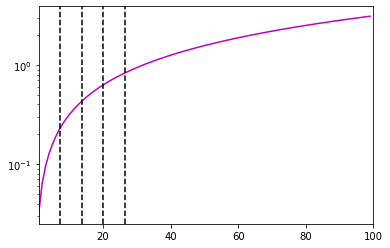

In [8]:
def lpcsp(a, lsp):
    # 주파수 응답 계산
    HH, FF = freqz([1], a, 100)
    
    # 주파수 응답을 로그 스케일로 플로팅
    plt.semilogy(np.abs(HH), 'm-')
    
    # 현재 축을 저장
    V = plt.axis()
    
    # 축 설정
    plt.axis([1, len(FF), V[2], V[3]])
    
    # lsp 위치에 선을 추가
    lsc = 100 / np.pi
    for lp in range(len(lsp)):
        plt.axvline(x=1 + lsp[lp] * lsc, color='k', linestyle='--')
    
    # 플롯 보여주기
    plt.show()

# 예시로 LPC 계수와 LSP를 설정
a = np.array([1, -1.6187, 2.3179, -2.9555, 2.8862, -2.5331, 2.2299, -1.3271, 0.9886, -0.6126, 0.2354])  # 예시 LPC 계수
lsp = np.array([0.2, 0.4, 0.6, 0.8])  # 예시 LSP 값

# 함수 호출
lpcsp(a, lsp)

### 5.3 Pitch models

#### 5.3.2 LTP pitch extraction

##### 5.3.2.1 Pitch extraction

In [9]:
def ltp(sp):
    n = len(sp)
    
    # 피치 검색 범위 설정
    pmin = 50
    pmax = 200
    
    # 시간 절약을 위해 신호 제곱을 미리 계산
    sp2 = sp ** 2
    
    # E 배열 계산
    E = []
    for M in range(pmin, pmax + 1):
        e_del = sp[:n - M]
        e = sp[M:]
        e2 = sp2[M:]
        E.append(np.sum((e_del * e) ** 2) / np.sum(e2))
    
    # 최적의 피치 주기 M 찾기
    M_opt = np.argmax(E) + pmin
    
    # 피치 이득 B 계산
    e_del = sp[:n - M_opt]
    e = sp[M_opt:]
    e2 = sp2[M_opt:]
    B = np.sum(e_del * e) / np.sum(e2)
    
    return B, M_opt

# 예시 신호 sp
sp = np.random.randn(1000)  # 예시로 랜덤 신호 생성

# 함수 호출
B, M = ltp(sp)
print(f"Pitch Gain (B): {B}, Pitch Period (M): {M}")

Pitch Gain (B): 0.01774190809829751, Pitch Period (M): 195
